In [219]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, recall_score, f1_score



In [220]:
df = pd.read_csv('../../resources/openstack/log-structured/OpenStack.log_sequences.csv')

In [221]:
X = df.iloc[:, 1:-1].values
y = df["Severity"].values
print(X.shape, y.shape)

(939, 62) (939,)


In [222]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [223]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [224]:
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)


In [225]:
class LogisticRegressionModel(nn.Module):
    def __init__(self, input_dim):
        super(LogisticRegressionModel, self).__init__()
        self.linear = nn.Linear(input_dim, 1)  # one output neuron

    def forward(self, x):
        return torch.sigmoid(self.linear(x))  # logistic (sigmoid) activation

model = LogisticRegressionModel(input_dim=X_train.shape[1])


In [226]:
criterion = nn.BCELoss()  # binary cross-entropy
optimizer = optim.SGD(model.parameters(), lr=0.1)

In [227]:
num_epochs = 50

for epoch in range(num_epochs):
    # Forward pass
    outputs = model(X_train)
    loss = criterion(outputs, y_train)

    # Backward pass
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Print progress
    if (epoch+1) % 100 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")


In [228]:
with torch.no_grad():  # disables gradient computation
    y_pred_probs = model(X_test)            # predicted probabilities, shape [N,1]
    y_pred = (y_pred_probs > 0.5).float()   # convert probabilities to 0/1 labels


In [229]:
y_pred_np = y_pred.numpy().flatten()  # flatten to 1D
y_test_np = y_test.numpy().flatten()

print("Predicted labels:", y_pred_np)

accuracy = accuracy_score(y_test_np, y_pred_np)
recall = recall_score(y_test_np, y_pred_np)
f1 = f1_score(y_test_np, y_pred_np)

print(f"Accuracy: {accuracy*100:.2f}%")
print(f"Recall: {recall*100:.2f}%")
print(f"F1 Score: {f1:.2f}")


Predicted labels: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Accuracy: 96.81%
Recall: 0.00%
F1 Score: 0.00


In [230]:
coefficients = model.linear.weight.detach().numpy().flatten()
event_names = list(df.columns)[1:-1] # if hasattr(X_train, 'columns') else [f"E{i+1}" for i in range(len(coefficients))]

feature_importance = pd.DataFrame({
    "EventId": event_names,
    "Coefficient": coefficients
})

# Sort by absolute value
feature_importance["Importance"] = feature_importance["Coefficient"].abs()
feature_importance = feature_importance.sort_values(by="Importance", ascending=False)

print(feature_importance.head(10))

             EventId  Coefficient  Importance
43  request-416be887    -0.222540    0.222540
39  request-31318a67     0.176225    0.176225
25    other-bc0f0d5b     0.160426    0.160426
28    other-edb74594     0.155946    0.155946
3     other-11db8690     0.144748    0.144748
16    other-7fcec85c     0.141673    0.141673
60  request-ef1ae852     0.123383    0.123383
0     other-027c0783     0.117129    0.117129
4     other-12b67311     0.114548    0.114548
41  request-34587f11     0.109498    0.109498


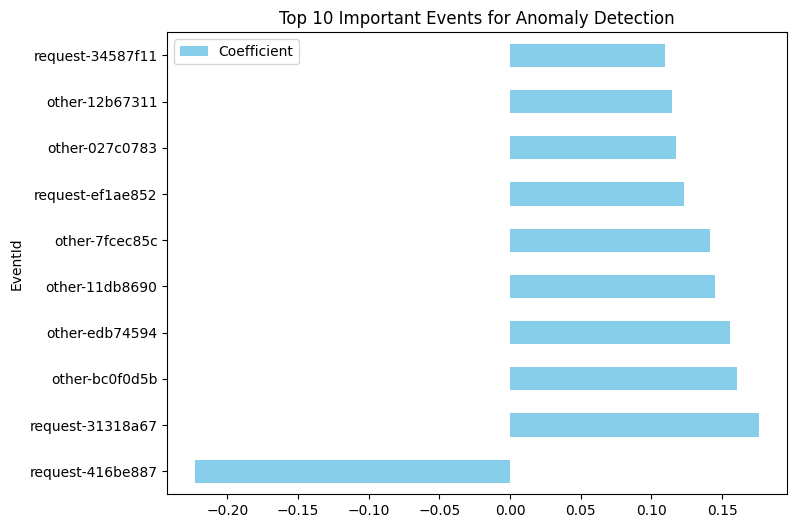

In [231]:
import matplotlib.pyplot as plt

feature_importance.head(10).plot(
    x="EventId", y="Coefficient", kind="barh", figsize=(8,6), color="skyblue"
)
plt.title("Top 10 Important Events for Anomaly Detection")
plt.show()
